# Teknofest-2024 AI in Healthcare

# Step 1 - Analysis of Mammography Images with Computer Vision

# Necessary Imports

In [53]:
# Dataset Operations
import numpy as np
import pandas as pd

# File Operations
import os
import glob
import pydicom

# Model Operations
import tensorflow as tf  # For tf.data
import matplotlib.pyplot as plt
import cv2
import keras
from keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Data Preprocessing

## Data Augmentation

# Step 1.1 Mass Detection (Kitle Tespiti)

## Load the Dataset 

In [60]:
def load_dicom_image(file_path):
    try:
        # Load the DICOM file
        dicom = pydicom.dcmread(file_path)

        # Get the pixel array from the DICOM file
        image = dicom.pixel_array

        # Save the original size of the image
        original_image_size = image.shape

        # Normalize the pixel values to [0, 1]
        image = (image - np.min(image)) / (np.max(image) - np.min(image))

        # Convert the image to 8-bit
        image = (image * 255).astype(np.uint8)

        # Convert to RGB (EfficientNetB0 expects 3 channels)
        if len(image.shape) == 2:  # grayscale
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        # Resize the image to (224, 224)
        image = cv2.resize(image, (224, 224))

        return image, original_image_size

    except ValueError: # Corrupt files
        print("Corrupt file: ", file_path)

## Load the csv file

In [55]:
def load_dataset(root_dir, csv_path):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_path, delimiter=";")

    # Update the df (in mass detection, only mass entries and entries without any mass are required)
    df = df[(df['ETİKET ADI'] == "Kitle") | (df['ETİKET ADI'] == "Normal")]
    
    # Code block to see the occurrences of each label
    #print("Normal Count:", df['ETİKET ADI'].value_counts()['Normal'])
    #print("Kitle Count:", df['ETİKET ADI'].value_counts()['Kitle'])
    
    images = []
    labels = []
    bounding_boxes = []

    for index, row in df.iterrows():
        # Construct the file path from the DataFrame
        file_path = os.path.join(root_dir, str(row['KATEGORİ']), str(row['HASTA ID']), str(row['DOSYA ADI']))

        # if kitle, then label is 1; otherwise label is 0
        if row.values[3] == "Kitle":
            label = 1
        else:
            label = 0

        # Load and preprocess the image
        try:
            image, original_image_size = load_dicom_image(file_path)
            images.append(image)
        except FileNotFoundError:
            print("File not found (corrupt file): ", file_path)
            continue
            
        # Extract the bounding box coordinates
        if pd.isna(row.values[4]):
            continue
        else:
            bounding_box = extract_bounding_box_coordinates(row.values[4].split('|'))
            bounding_box = normalize_bounding_box(bounding_box, original_image_size, (224, 224))

        labels.append(label)
        bounding_boxes.append(bounding_box)
        
        !!!visualize_bounding_box(image, bounding_box) # IMPORTANT !!!
    
    np_images = np.array(images)
    np_labels = np.array(labels)
    np_bounding_boxes = np.array(bounding_boxes)
    
    return np_images, np_labels, np_bounding_boxes

In [56]:
def visualize_bounding_box(image, bounding_box):
    """
    Visualize a bounding box on an image.

    Parameters:
    image (np.array): The image on which to draw the bounding box.
    bounding_box (list): The bounding box coordinates in the format [x1, y1, x2, y2, x3, y3, x4, y4].

    Returns:
    None
    """
    # Convert the bounding box coordinates to integers
    bounding_box = [int(coord) for coord in bounding_box]

    # The bounding box coordinates are assumed to be in the format [x1, y1, x2, y2, x3, y3, x4, y4]
    points = np.array([[bounding_box[i], bounding_box[i + 1]] for i in range(0, len(bounding_box), 2)])

    # Draw the bounding box on the image
    cv2.polylines(image, [points], True, (255, 0, 0), 1)

    # Display the image
    plt.imshow(image)
    plt.show()

In [57]:
def normalize_bounding_box(bounding_box, original_image_size, new_image_size):
    """
    Normalize the bounding box coordinates based on the new image size.

    Parameters:
    bounding_box (list): The bounding box coordinates in the format [x1, y1, x2, y2, x3, y3, x4, y4].
    original_image_size (tuple): The original size of the image in the format (width, height).
    new_image_size (tuple): The new size of the image in the format (width, height).

    Returns:
    list: The normalized bounding box coordinates.
    """
    scale_factor_x = new_image_size[0] / original_image_size[0]
    scale_factor_y = new_image_size[1] / original_image_size[1]

    # Normalize the x-coordinates
    bounding_box[::2] = [coord * scale_factor_x for coord in bounding_box[::2]]

    # Normalize the y-coordinates
    bounding_box[1::2] = [coord * scale_factor_y for coord in bounding_box[1::2]]

    return bounding_box

In [58]:
def extract_bounding_box_coordinates(bounding_box_list):
    new_list = []
    for bounding_box in bounding_box_list:
        x = float(bounding_box.split('/')[0])
        y = float(bounding_box.split('/')[1])
        new_list.append(x)
        new_list.append(y)
    return new_list

File not found (corrupt file):  /Users/abdulkadir/Desktop/teknofest_data/image_data/Kategori1/10080/LCC.dcm
File not found (corrupt file):  /Users/abdulkadir/Desktop/teknofest_data/image_data/Kategori1/10222/RMLO.dcm
File not found (corrupt file):  /Users/abdulkadir/Desktop/teknofest_data/image_data/Kategori1/10494/LCC.dcm
File not found (corrupt file):  /Users/abdulkadir/Desktop/teknofest_data/image_data/Kategori1/10729/RMLO.dcm


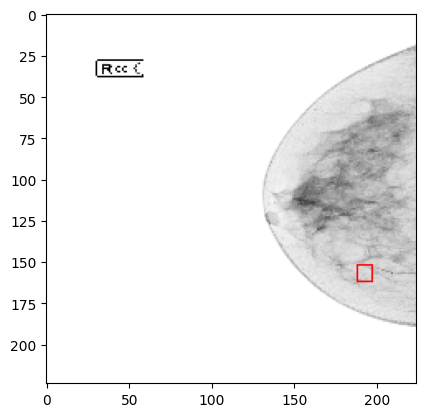

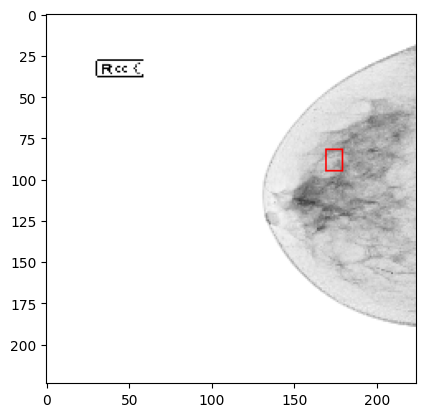

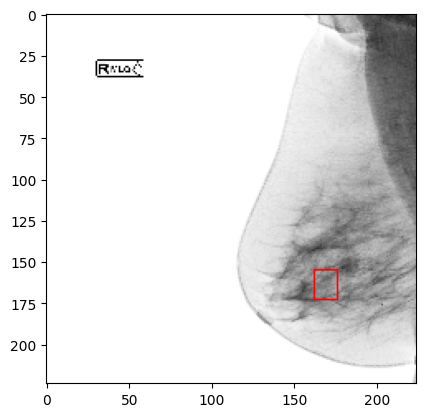

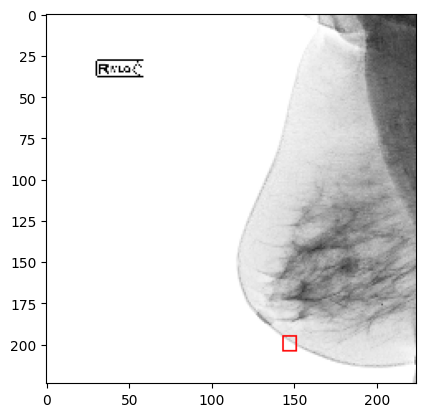

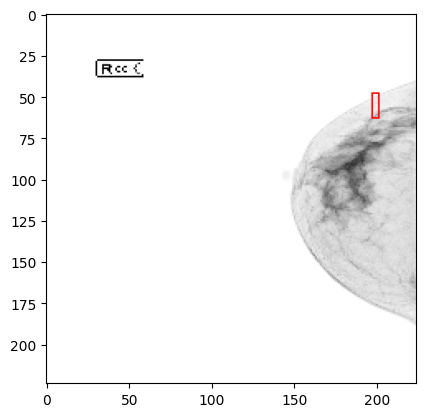

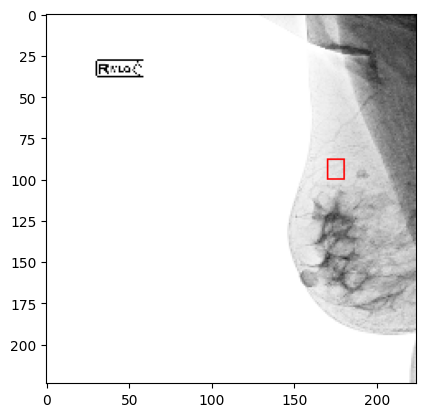

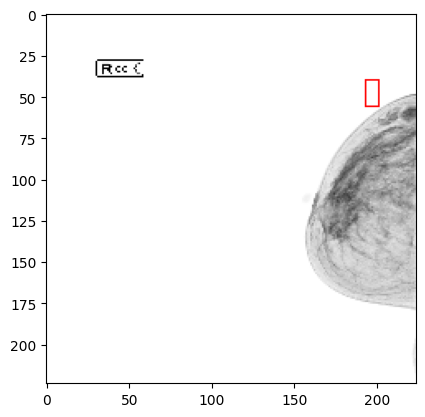

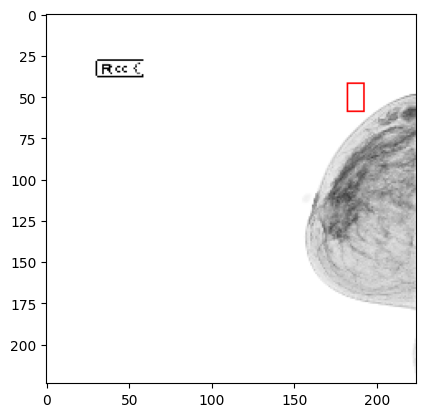

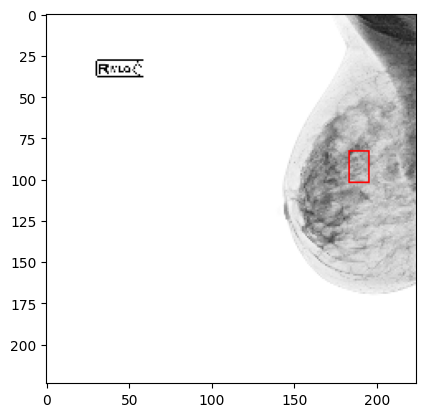

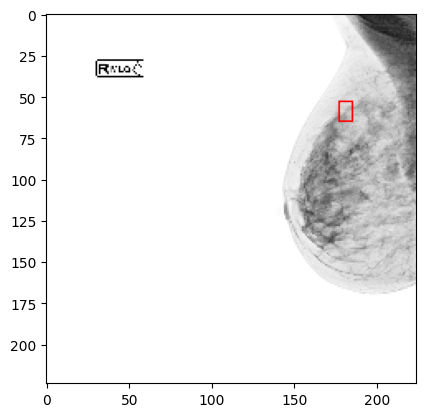

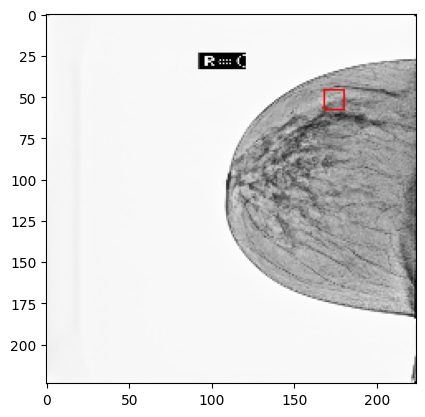

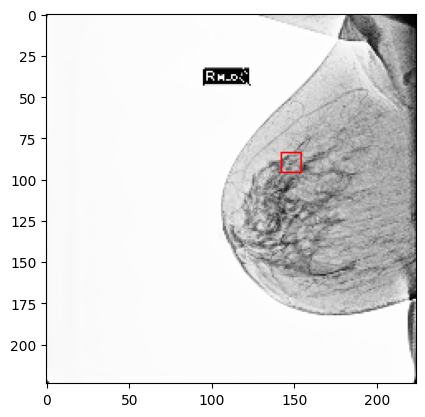

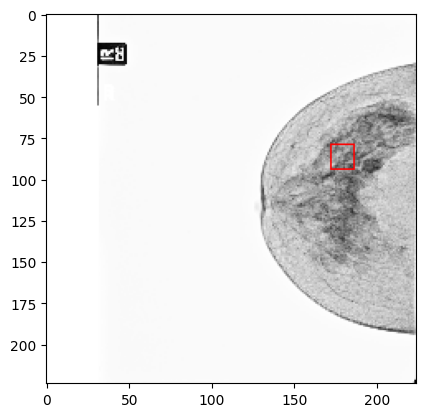

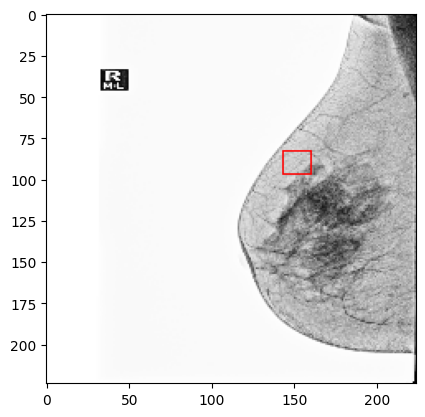

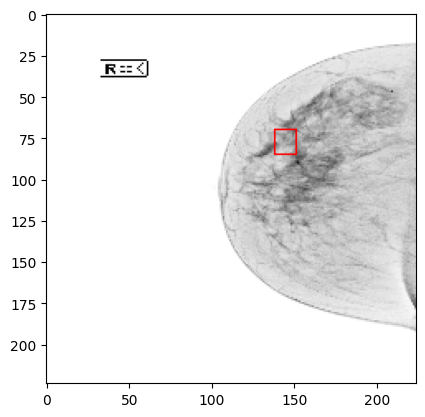

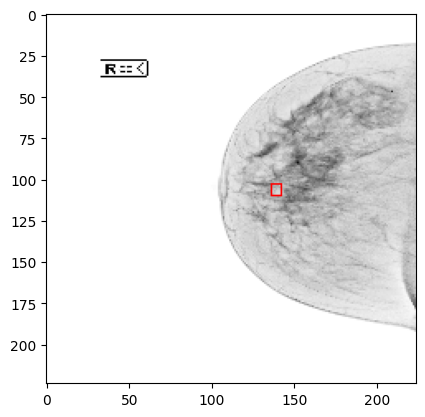

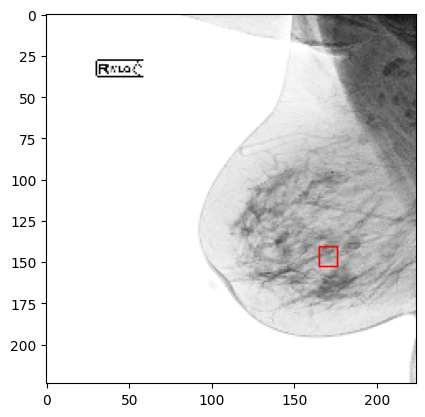

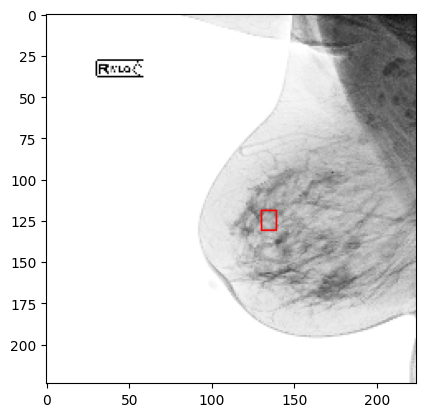

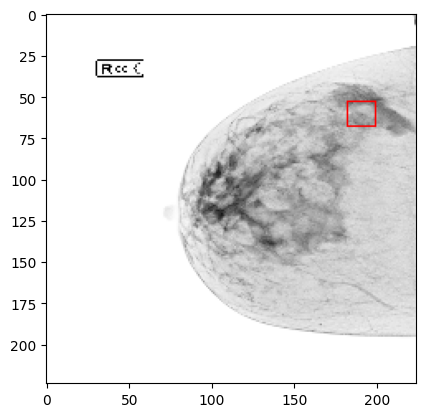

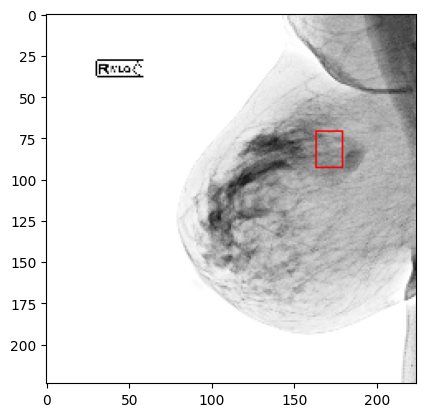

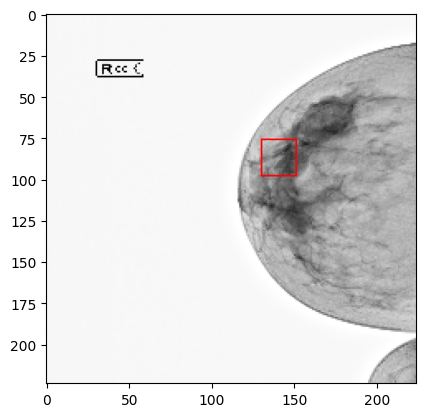

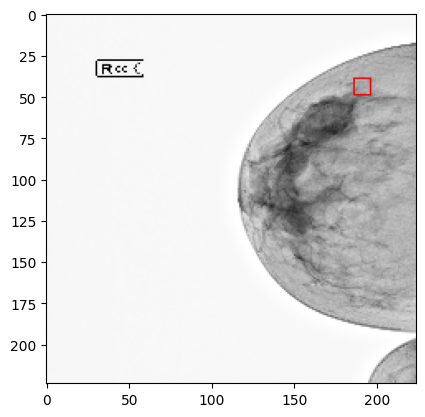

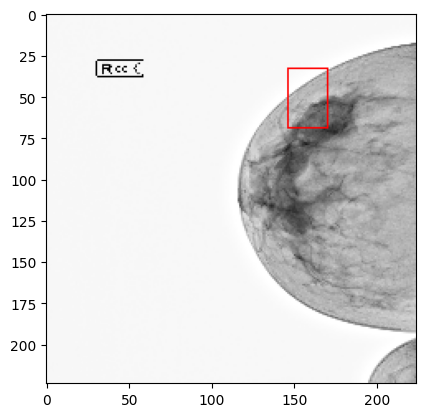

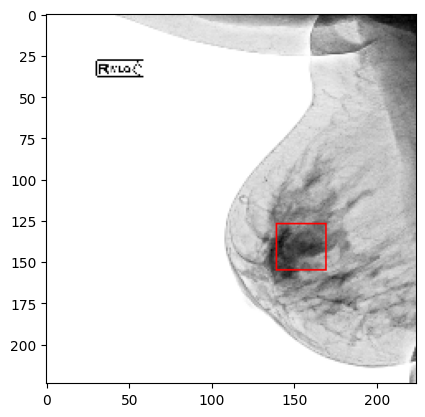

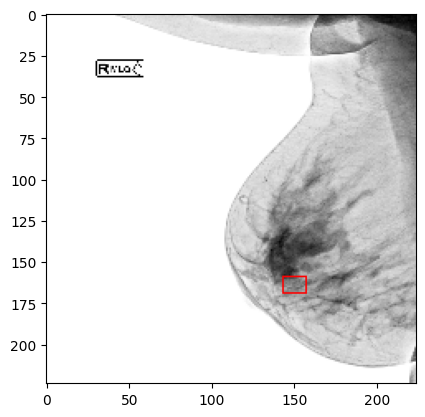

KeyboardInterrupt: 

In [61]:
# Load the dataset
root_dir = "/Users/abdulkadir/Desktop/teknofest_data/image_data"
csv_path = "/Users/abdulkadir/Desktop/Teknofest2024/veribilgisi.csv"
images, labels, bounding_boxes = load_dataset(root_dir, csv_path)

# Split the dataset into training and test sets with shuffling
images_train, images_test, labels_train, labels_test, bounding_boxes_train, bounding_boxes_test = train_test_split(images, labels, bounding_boxes, test_size=0.2, shuffle=True)

# Now, images_train, labels_train, and bounding_boxes_train are your training set.
# And images_test, labels_test, and bounding_boxes_test are your test set.

# Train the model

In [44]:
from sklearn.model_selection import KFold
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

# Define the number of folds for k-fold cross-validation
num_folds = 5

# Define the L2 regularization factor
l2_reg = 0.01

# Initialize the base model
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')

# Add a dropout layer
x = Dropout(0.5)(base_model.output)

# Add custom output layers with L2 regularization
output_layer1 = Dense(1, activation='sigmoid', name='classification', kernel_regularizer=l2(l2_reg))(x)
output_layer2 = Dense(8, name='regression', kernel_regularizer=l2(l2_reg))(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=[output_layer1, output_layer2])

# Compile the model
model.compile(optimizer=Adam(), loss={'classification': 'binary_crossentropy', 'regression': 'mae'},
              metrics={'classification': 'accuracy', 'regression': 'mae'})

# Initialize the KFold object
kfold = KFold(n_splits=num_folds, shuffle=True)

# Loop over the folds
for train, test in kfold.split(images, labels):
    # Train the model
    history = model.fit(images[train], {'classification': labels[train], 'regression': bounding_boxes[train]},
                        validation_data=(images[test], {'classification': labels[test], 'regression': bounding_boxes[test]}),
                        epochs=4)

Epoch 1/4
70/70 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - classification_accuracy: 0.9155 - loss: 39.3003 - regression_mae: 38.9232 - val_classification_accuracy: 0.0000e+00 - val_loss: 52.5298 - val_regression_mae: 47.4166
Epoch 2/4
70/70 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - classification_accuracy: 0.9932 - loss: 26.1670 - regression_mae: 25.7040 - val_classification_accuracy: 0.0000e+00 - val_loss: 54.9192 - val_regression_mae: 53.6173
Epoch 3/4
27/70 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - classification_accuracy: 0.9955 - loss: 24.0083 - regression_mae: 23.5166

KeyboardInterrupt: 

## Evaluate the Model 

In [45]:
# Evaluate the model on the test set
total_loss, classification_metric, regression_metric = model.evaluate(images_test, {'classification': labels_test, 'regression': bounding_boxes_test})

print("Total loss:", total_loss)
print("Classification metric:", classification_metric)
print("Regression metric:", regression_metric)

18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 381ms/step - classification_accuracy: 1.0000 - loss: 48.5045 - regression_mae: 47.9715
Total loss: 48.90864181518555
Classification metric: 1.0
Regression metric: 48.37578201293945


## Test the Model

In [42]:
def test_model_with_image(model, image_path):
    # Load and preprocess the image
    image, original_image_size = load_dicom_image(image_path)

    # Add an extra dimension for the batch size
    image_batch = np.expand_dims(image, axis=0)

    # Predict the outputs
    predictions = model.predict(image_batch)

    # The predictions are in the form of a list with two elements
    classification_prediction = predictions[0][0]
    regression_prediction = predictions[1][0]

    # Rescale the image to 0-255
    image = (image * 255).astype(np.uint8)

    # Convert the bounding box coordinates to integers
    bounding_box = [int(coord) for coord in regression_prediction]

    # Scale the bounding box coordinates to match the image dimensions
    original_image_size = 1024  # replace with the size of the images the model was trained on
    new_image_size = 224  # replace with the size of the images used for prediction
    scale_factor = new_image_size / original_image_size
    bounding_box = [int(coord * scale_factor) for coord in bounding_box]

    # Invert the y-coordinates of the bounding box
    bounding_box[1::2] = [new_image_size - coord for coord in bounding_box[1::2]]

    # Print the bounding box coordinates
    print("Bounding box coordinates:", bounding_box)

    # Draw the bounding box on the image
    # The bounding box coordinates are assumed to be in the format [x1, y1, x2, y2, x3, y3, x4, y4]
    points = np.array([[bounding_box[0], bounding_box[1]],
                       [bounding_box[2], bounding_box[3]],
                       [bounding_box[4], bounding_box[5]],
                       [bounding_box[6], bounding_box[7]]])
    cv2.polylines(image, [points], True, (255, 0, 0), 1)
    
    # Display the image
    plt.imshow(image)
    plt.show()

    return classification_prediction, regression_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
Bounding box coordinates: [-10, 218, -11, 216, -10, 215, -10, 217]


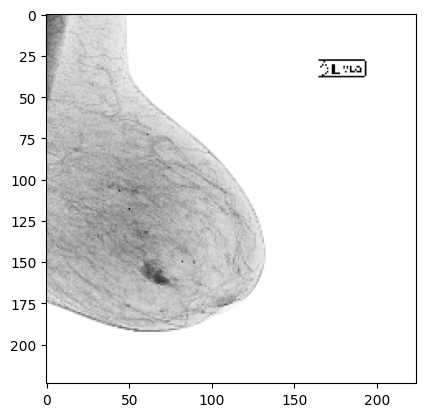

(array([1.], dtype=float32),
 array([-49.976456,  28.216675, -52.428417,  41.46955 , -49.29752 ,
         44.543087, -48.87192 ,  33.530804], dtype=float32))

In [43]:
test_model_with_image(model, "/Users/abdulkadir/Desktop/teknofest_data/image_data/Kategori4/12022/LMLO.dcm")